# <font color='gren'>Exercício 1

## **1-Imports Necessários**

In [13]:
import numpy as np
from numpy import random

import scipy
from scipy import linalg
from scipy.sparse import diags, linalg

import matplotlib.pylab as plt
from mpl_toolkits import mplot3d
from matplotlib import cm

import time

import random

## **2-Funções auxiliares**

* Função para plotar os curvas de nível constante de temperatura

In [14]:

def PlotaMembrane(N1,N2,L1,L2,W):
    x = np.linspace(0, L1, N1)
    y = np.linspace(0, L2, N2)
    X,Y=np.meshgrid(x,y)
    Z = np.copy(W)
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.set(xlabel='x', ylabel='y', title='Deslocamento vertical')
    im = ax.contourf(X, Y, Z, 20)
    im2 = ax.contour(X, Y, Z, 20, linewidths=0.25, colors='k')
    fig.colorbar(im, ax=ax)
    plt.show()
    
def PlotaSurface(N1,N2,L1,L2,W):
    x = np.linspace(0, L1, N1)
    y = np.linspace(0, L2, N2)
    X,Y=np.meshgrid(x,y)
    Z = np.copy(W)
    ax = plt.axes(projection ='3d')
    ax.plot_surface(X, Y, Z,cmap='viridis', edgecolor='none')
    ax.set(xlabel='x', ylabel='y', title='Deslocamento vertical')
    ax.set_zlim(-1.01, 1.01)
    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False)
    

* Montagem das matrizes K e M

In [15]:
def ij2n (i, j, N):
    return i + j*N

def BuildMatrizesEigen(N1, N2, sigma, rho, e, delta):
    nunk = N1*N2

    # Stiffness matrix K: Build it as a sparse matrix 
    d1 = 4.0*np.ones(nunk)
    d2 = -np.ones(nunk-1)
    d3 = -np.ones(nunk-N1)
    K = (sigma/delta**2)*scipy.sparse.diags([d3, d2, d1, d2, d3], [-N1, -1, 0, 1, N1], format='csr')

    # Force the eigenvalues associated to boundary points 
    # to be a big number as compared to fundamental modes
    big_number = 10000
    Iden = big_number*scipy.sparse.identity(nunk, format='csr')

    # Lados verticais
    for k in range(0,N2):
        Ic = ij2n(0,k,N1) # Left
        K[Ic,:], K[:,Ic] = Iden[Ic,:], Iden[:,Ic]

        Ic = ij2n(N1-1,k,N1) # Right
        K[Ic,:], K[:,Ic] = Iden[Ic,:], Iden[:,Ic]
        
    # Lados horizontais
    for k in range(0,N1):
        Ic = ij2n(k,0,N1) # Bottom
        K[Ic,:], K[:,Ic] = Iden[Ic,:], Iden[:,Ic]

        Ic = ij2n(k,N2-1,N1) # Top
        K[Ic,:], K[:,Ic] = Iden[Ic,:], Iden[:,Ic]

    # Mass matrix: Simple case, multiple of identity
    M = rho*e*scipy.sparse.identity(nunk, format='csr')
    
    return K, M    

## **3-Método Iterativo de Francis**

In [16]:
#   Função que encontra o maior elemento da matriz fora sua diagonal (i!=j)
def return_error(M):
    m=M
    np.fill_diagonal(m,0)
    m=np.absolute(m)
    e=m.max()
    return e

#   Função do método iterativo de Francis que retorna a matriz D de autovalores na diagonal e a matriz de autovetores Q
#com base em um erro ou um número máximo de iterações
def francis_metod(A,tol,T_max):
    Dold=A #Primeiro chute: D=A
    Dnew=Dold
    Vold=np.identity(len(A[0]))
    Vnew=Vold
    e,k=1,0
    while(e>tol and k<T_max):
        Q,R=scipy.linalg.qr(Dold)
        Dnew=np.matmul(R,Q)
        Vnew=np.matmul(Vold,Q)
        e=return_error(Dold) #while acabará quando o maior valor for muito próximo de zero ou as tentativas se esgotarem
        k+=1
        Dold=Dnew
        Vold=Vnew
    return Dold.diagonal(), Vnew


## **4-Tempo de processamento do método de Francis em função de n**

In [17]:
def temp_francis_metod(tol,T_max,n):
   A=np.zeros(shape=(n,n),dtype=float)
   random.seed()
   for i in range(n):
      for j in range(i,n):
         k=random.random()
         A[i][j],A[j][i]=k,k
   ti=time.time()
   Lam,Q=francis_metod(A,tol,T_max)
   tf=time.time()-ti
   return tf


## **5-Plots de resultados**

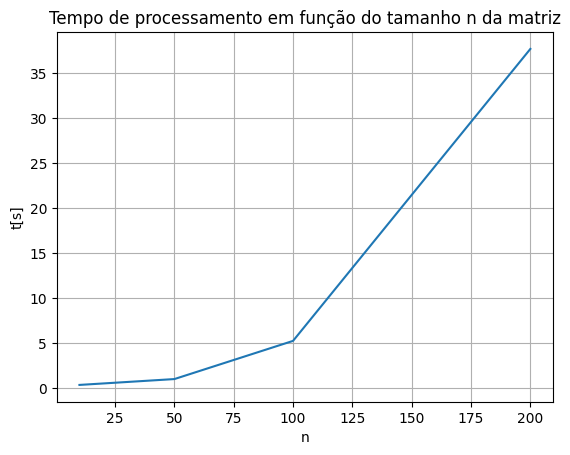

In [18]:
#Pré-setagem
tol=10**(-8)
T_max=10000

#Definição dos eixos x e y do mapa a ser plotado
x=np.array([10,50,100,200],dtype=int)
y=np.array([])
for i in range(len(x)):
    y=np.append(y,temp_francis_metod(tol,T_max,x[i]))

plt.plot(x,y)
plt.grid()
plt.xlabel('n')
plt.ylabel('t[s]')
plt.title('Tempo de processamento em função do tamanho n da matriz')
plt.show()

